<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/SemanticSegmentationOnLargeDataset_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --recursive --no-parent https://www.cs.toronto.edu/~vmnih/data/mass_buildings/train/sat/index.html -q
!wget --recursive --no-parent https://www.cs.toronto.edu/~vmnih/data/mass_buildings/train/map/index.html -q

In [2]:
!pip install split-folders
!pip install focal-loss 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import splitfolders

# Specify the input folder containing the images
input_folder = '/content/www.cs.toronto.edu/~vmnih/data/mass_buildings/train'

# Specify the output folder where the train, test, and validation sets will be created
output_folder = 'Data'

# Set the desired ratio for train, test, and validation splits (e.g., 70%, 15%, 15%)
split_ratio = (0.7, 0.15, 0.15)

# Perform the split using splitfolders
splitfolders.ratio(input_folder, output_folder, ratio=split_ratio, seed=42)


Copying files: 276 files [00:06, 42.43 files/s]


# Folder stucture for senmantic segmentation

For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.
Data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                
    val_masks/
                val/
                    msk1, msk, msk3, ......
      
    test_images/
                test/
                    img1, img2, img3, ......    
                    
    test_masks/
                test/
                    msk1, msk, msk3, ......
Use split-folders library (pip install split-folders) to make this process of splitting
files easy. 

# Model Building


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model




# Creating image generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed=24
batch_size= 8
img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("Data/train_images/", 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("Data/train_masks/", 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("Data/val_images/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("Data/val_masks/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


Found 96 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
Found 19 images belonging to 1 classes.


In [12]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

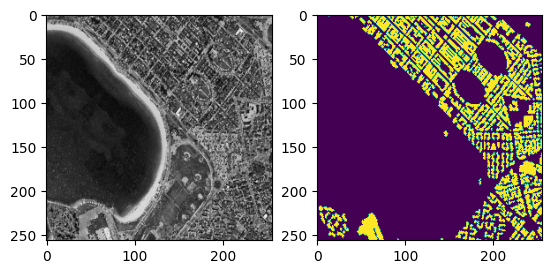

In [19]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [20]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [21]:
input_shape

(256, 256, 3)

In [22]:
from keras import backend as K
#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0
    return 2*intersection / union

In [23]:
model = build_unet(input_shape)

In [24]:
from focal_loss import BinaryFocalLoss

In [25]:
model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), 
              metrics=[dice_metric])

In [26]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
import os
num_train_imgs = len(os.listdir('Data/train_images/train/'))

steps_per_epoch = num_train_imgs //batch_size

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=5)


Epoch 1/5
12/12 [==============================] - 893s 75s/step - loss: 0.1774 - dice_metric: 0.0021 - val_loss: 1.3122 - val_dice_metric: 0.0020
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 0.1234 - dice_metric: 0.0026 

In [ ]:
model.save('mitochondria_load_from_disk.hdf5')



#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_metric']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_metric']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

##############################################################
#Test the model on images we held out for testing.
#We can use the generator again for predictions. 
#Remember that this is not test time augmentation. This is only using augmentaton
#to load images from the drive, perfomr augmentation and predict. 
# TTA means predicting on augmenting images and then combining predictions for better
#accuracy. 

model = tf.keras.models.load_model("mitochondria_load_from_disk_focal_dice_50epochs.hdf5", compile=False)

test_img_generator = image_data_generator.flow_from_directory("Data/test_images/", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("Data/test_masks/", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here

### Testing on a few test images

a = test_img_generator.next()
b = test_mask_generator.next()
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average
 
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU) 